In [12]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
from requests_testadapter import Resp
import requests
#from requests_file import FileAdapter
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import nltk


In [11]:
df_reviews = pd.read_csv('reviews_sep2_clean.csv')

In [20]:
df_reviews.head(3)

,resto,fecha,review,comida,servicio,ambiente,tokened,normal,nonstop,nopoint
0,-amigos-del-mar-608,12/07/2015,el mejor lugar de la Argentina para comer comi...,Excelente,Excelente,Excelente,"['el', 'mejor', 'lugar', 'de', 'la', 'Argentin...","['el', 'mejor', 'lugar', 'de', 'la', 'argentin...","['mejor', 'lugar', 'argentina', 'comer', 'comi...","['mejor', 'lugar', 'argentina', 'comer', 'comi..."
1,-amigos-del-mar-608,22/06/2015,"El Curry Udon excelente, hacía mucho que no co...",Muy bueno,Excelente,Excelente,"['El', 'Curry', 'Udon', 'excelente', ',', 'hac...","['el', 'curry', 'udon', 'excelente', ',', 'hac...","['curry', 'udon', 'excelente', ',', 'hacía', '...","['curry', 'udon', 'excelente', 'hacía', 'comía..."
2,-amigos-del-mar-608,06/01/2015,La relación calidad-precio fue mala (muy caro ...,Muy bueno,Regular,Muy bueno,"['La', 'relación', 'calidad-precio', 'fue', 'm...","['la', 'relación', 'calidad-precio', 'fue', 'm...","['relación', 'calidad-precio', 'mala', '(', 'c...","['relación', 'calidad-precio', 'mala', 'caro',..."


In [18]:
corpus = df_reviews.nopoint

In [45]:
# Vectorizamos el texto con TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, use_idf=True) #le saque el stopwords, porque ya lo hicimos antes

X = vectorizer.fit_transform(corpus)

print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 28286, n_features: 10000


In [50]:
features = vectorizer.get_feature_names()
top_n = 2
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

NameError: name 'indices' is not defined

In [22]:
#Vemos la frecuencia de las palabras más comunes
dist = nltk.FreqDist(corpus)
dist



FreqDist({"['excelente']": 23, '[]': 10, "['recomendable']": 7, "['come', 'rico', 'nunca', 'caro']": 7, "['buena', 'comida']": 6, "['rico']": 6, "['bueno']": 6, "['bien']": 6, "['excelente', 'lugar']": 5, "['ir', 'restaurant', 'comida', 'húngara', 'comer', 'suprema', 'vayas']": 4, ...})

In [23]:
#Aplicamos un tipo de reducción de la dimensionalidad (SVD truncado). A diferencia de PCA
#No centra los datos, lo que le permite funcionar con matrices esparsas.
#recibe la matriz de vectores TD-IDF para el análisis LSA

svd = TruncatedSVD(100,random_state = 1) 
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

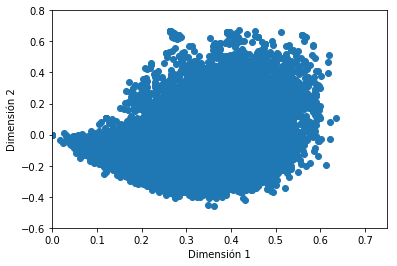

In [39]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.axis([0, 0.75, -0.6, 0.8])
plt.show()

In [38]:
# Clusterizamos con KMeans
k_value = 3
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k_value, max_iter=100, n_init=10, random_state = 10)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [42]:
# Hacemos la transformación inversa para ver el peso de los features originales (10000 dim)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

# La función argsort nos da los índices ordenados
order_centroids = original_space_centroids.argsort()[:, ::-1]

# Imprimimos los términos más "pesados" (frecuentes) para cada categoría
# Con los índices ordenados, llamamos a la descripción de las palabras que construyó el Vectorizer()
terms = vectorizer.get_feature_names()

print("Ranking de términos por tópico:")

for i in range(k_value):
    print(end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

# Nos quedamos con los índices ordenados más importantes en cada tópico

Ranking de términos por tópico:
 excelente comida atención lugar buena calidad ambiente recomendable atencion platos precio bien precios siempre servicio buen recomiendo mejor ir carta
 buena lugar comida bien atención ambiente precios platos calidad precio buen comer ir pizza bueno mejor lindo atencion rica siempre
 pedimos si mas comida dos mala plato mal mesa lugar papas mozo solo vino bien atención nunca platos carne postre


In [ ]:
#podemos ver en los resultados, que los primeros dos topics apuntan a una buena experiencia y el tercero
#apunta a una experiencia negativa

#probamos nuevamente con 2 temas.

In [43]:
k_value = 2
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k_value, max_iter=100, n_init=10, random_state = 10)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [44]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
print("Ranking de términos por tópico:")

for i in range(k_value):
    print(end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

# Nos quedamos con los 10 índices ordenados más importantes en cada tópico
# Los tópicos parecen tener sentido: Tópico 0(religion), Tópico 1(gráficos) y Tópico 2(espacio)

Ranking de términos por tópico:
 buena comida lugar excelente atención ambiente calidad bien platos precios precio buen atencion recomendable ir lindo carta agradable siempre comer
 lugar bien si pedimos mas comida pizza dos comer platos atención plato papas mesa mala mal servicio bueno solo carne
